## Машинное обучение 

### Факультет математики НИУ ВШЭ, 2019-20 учебный год

_Илья Щуров, Соня Дымченко, Руслан Хайдуров, Александр Каган, Павел Балтабаев_

[Страница курса](http://wiki.cs.hse.ru/Машинное_обучение_на_матфаке_2020)


## Домашнее задание 4. Линейные модели и градиентный спуск.

В данном задании необходимо реализовать обучение логистической и линейной регрессий с помощью различных вариантов градиентного спуска.

Правила оценивания найдите на странице курса.

## Часть 1: Реализация градиентного спуска.

Реализуйте логистическую регрессию с лог-лоссом, обучаемую с помощью:

**Задание 1 (1 балл)** Градиентного спуска;

**Задание 2 (1.5 балла)** Стохастического градиентного спуска;

**Задание 3 (1.5 балла)** Стохастического градиентного спуска с Momentum.

Подробнее о методах можно прочитать [тут](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture02-linregr.pdf). Напомним, что лог-лосс вычисляется по формуле
$$
    \mathcal{L}(y, X, w) = -\cfrac{1}{n} \sum_{i=1}^{n} [y_i=1]\log \sigma(\langle w, x_i\rangle) + [y_i=0]\log (1 - \sigma(\langle w, x_i\rangle)) + \lambda_2 ||w||_2^2 + \lambda_1 ||w||_1
$$
где $\sigma(x) = 1 / (1 + \exp(-x))$, а $\lambda_1, \lambda_2 > 0$ -- параметры регуляризации. Считайте, что либо $\lambda_1 = 0$, либо $\lambda_2 = 0$. 

Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска в методе fit; также разрешается использовать только стандартные средства языка Python и библиотеку numpy.
* Обучение необходимо приостанавливать, если выполнено хотя бы одно из двух условий:

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [1]:
import numpy as np
from sklearn.base import BaseEstimator


class LogReg(BaseEstimator):
    def __init__(self, lambda_1=0.0, lambda_2=1.0, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, nu=0.0, beta_1=0.9, beta_2=0.999, eps=1e-8):
        """
        lambda_1: L1 regularization param
        lambda_2: L2 regularization param
        gd_type: 'full', 'stochastic' or 'momentum' + 'adam' 
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        nu: param for 'momentum' method of gd. 
        beta_1: param1 for adam method
        beta_2: param2 for adam method
        eps: less then eps is 0
            By default is 0, what means it is same is full method until changed
        """
        if lambda_1 * lambda_2 != 0:
            self.lambda_1 = 0
            self.lambda_2 = 0
            raise Exception('Double regularization')
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.gd_type = gd_type
        self.nu = nu
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = w0
        self.alpha = alpha
        self.beta_1, self.beta_2 = beta_1, beta_2
        self.eps = eps
        self.loss_history = []

    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        l, d = X.shape
        if self.w is None:
            self.w = np.random.uniform(0, 1, d)
        
        if self.gd_type == 'full':
            return self.fit_mode_full(X, y)
        elif self.gd_type == 'stochastic':
            return self.fit_mode_stochastic(X, y)
        elif self.gd_type == 'momentum':
            return self.fit_mode_momentum(X, y)
        elif self.gd_type == 'adam':
            return self.fit_mode_adam(X, y)
        else:
            raise Exception('Unknown gd_type')

    def fit_mode_full(self, X, y):
        """
        ....
        :param X: np.array of shape (l, d)
        :param y: np.array of shape (l)
        :return: fitted wieght
        """
        l, d = X.shape
        for i in range(self.max_iter):
            last_w = self.w.copy()
            self.loss_history.append(self.calc_loss(X, y))
            self.w -= self.calc_gradient(X, y)
            if np.linalg.norm(last_w - self.w) <= self.tolerance:
                print('finished at step {} out of {}'.format(i, self.max_iter))
                break
        return self.w

    def fit_mode_stochastic(self, X, y):
        """
        ....
        :param X: np.array of shape (l, d)
        :param y: np.array of shape (l)
        :return: fitted wieght
        """
        l, d = X.shape
        for i in range(self.max_iter):
            last_w = self.w.copy()
            random_select = np.random.randint(0, l-1, d)
            X_calc, y_calc = X[random_select], y[random_select]
            self.loss_history.append(self.calc_loss(X_calc, y_calc))
            self.w -= self.calc_gradient(X_calc, y_calc)
            if np.linalg.norm(last_w - self.w) <= self.tolerance:
                print('finished at step {} out of {}'.format(i, self.max_iter))
                break
        return self.w

    def fit_mode_momentum(self, X, y):
        """
        ....
        :param X: np.array of shape (l, d)
        :param y: np.array of shape (l)
        :return: fitted wieght
        """
        l, d = X.shape
        self.gradient = 0
        for i in range(self.max_iter):
            last_w = self.w.copy()
            random_select = np.random.randint(0, l-1, d)
            X_calc, y_calc = X[random_select], y[random_select]
            self.loss_history.append(self.calc_loss(X_calc, y_calc))
            self.gradient = self.nu * self.gradient + self.calc_gradient(X_calc, y_calc)
            self.w -= self.gradient
            if np.linalg.norm(last_w - self.w) <= self.tolerance:
                print('finished at step {} out of {}'.format(i, self.max_iter))
                break
        return self.w
    
    def fit_mode_adam(self, X, y):
        """
        ....
        :param X: np.array of shape (l, d)
        :param y: np.array of shape (l)
        :return: fitted wieght
        """
        l, d = X.shape
        self.m, self.v = 0, 0
        for i in range(1, self.max_iter):
            last_w = self.w.copy()
            random_select = np.random.choice(l, min(l, 1000), 1)
            self.loss_history.append(self.calc_loss(X, y))
            gradient = self.calc_gradient(X[random_select], y[random_select])
            self.m = self.m * self.beta_1 + (1 - self.beta_1) * gradient
            self.v = self.v * self.beta_2 + (1 - self.beta_2) * np.square(gradient)
            self.w -= self.alpha * (self.m / (1 - self.beta_1 ** i)) / (np.sqrt((self.v / (1 - self.beta_2 ** i))) + self.eps)
            if np.linalg.norm(last_w - self.w) <= self.tolerance:
                break
        return self.w

    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        return np.array([1 - self.sigma((X @ self.w)), self.sigma(X @ self.w)]).T

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        l, d = X.shape
        reg = self.lambda_1 * np.sign(self.w) + 2 * self.lambda_2 * self.w
        loss = (self.sigma(X @ self.w) - y) @ X
        return self.alpha * (loss / l + reg)

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """
        l, d = X.shape
        reg = self.lambda_1 * np.sum(np.abs(self.w)) + self.lambda_2 * np.sum(np.power(self.w, 2))
        loss = np.sum(np.where(y == 1, np.log(self.sigma(X @ self.w)), np.log(1 - self.sigma(X @ self.w))))
        return - loss / l + reg

    def sigma(self, x):
        """
        :param x: input value or vector 
        :return: sigmoid value or vector
        """
        return 1 / (1 + np.exp(-x))


In [2]:
X = np.array([[-2.2], [-1.4], [-.8], [.2], [.4], [.8], [1.2], [2.2], [2.9], [4.6]])
y = np.array([0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
w = None

full = LogReg(lambda_2=0.1, w0=w, alpha=0.001, max_iter=100000, tolerance=0.00001,
              gd_type='full')
print('Full gd_type')
print('w= ', full.fit(X, y))
print(full.calc_loss(X, y), '\n')

st = LogReg(lambda_2=0.1, w0=w, alpha=0.001, max_iter=100000, tolerance=0.00001,
            gd_type='stochastic')
print('Stochastic gd_type')
print('w= ', st.fit(X, y))
print(st.calc_loss(X, y), '\n')

mm = LogReg(lambda_2=0.1, w0=w, alpha=0.001, max_iter=100000, tolerance=0.00001,
            gd_type='momentum', nu=0.02)
print('Momentum gd_type:')
print('w=', mm.fit(X, y))
print(mm.calc_loss(X, y), '\n')

adam = LogReg(lambda_2=0.1, w0=w, alpha=0.001, max_iter=100000, tolerance=0.00001,
            gd_type='adam', beta_1=0.9, beta_2=0.99)
print('adam gd_type:')
print('w=', adam.fit(X, y))
print(adam.calc_loss(X, y), '\n')



Full gd_type
finished at step 4439 out of 100000
w=  [0.76513248]
0.4492047742854665 

Stochastic gd_type
finished at step 12361 out of 100000
w=  [0.79350426]
0.4491450557757136 

Momentum gd_type:
finished at step 44 out of 100000
w= [0.82777049]
0.4496551233217202 

adam gd_type:
w= [0.7729235]
0.44914394976051775 



**Задание 4 (0 баллов)**. 
* Загрузите обучающие данные с соревнования [Porto Seguro](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction);
* Пересэмплируйте её так, чтобы объектов положительного и отрциательного классов было поровну;
* Разбейте выборку на обучающую и тестовую в отношении 7:3.

Ладно, мы сделали это за вас. =)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/portoseguro.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

In [4]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 5000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 5000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

**Задание 5 (1.5 балла)**. Обучите и провалидируйте все три метода из заданий 1-3 на данных из предыдущего пункта, сравните качество между методами по метрике AUC-ROC и F-мере. Исследуйте влияние параметров `max_iter` и `eta` (`max_iter`, `alpha` и `eta` для Momentum) на процесс оптимизации. Согласуется ли оно с вашими ожиданиями? (здесь подразумеваются графики, на которых отображаются значения метрик в зависимости от значения параметра).

In [5]:
from time import time

np.random.seed(90300)
w0_full = np.random.uniform(0, 1, X_train.shape[1])
w0_st = np.random.uniform(0, 1, X_train.shape[1])
w0_mm = np.random.uniform(0, 1, X_train.shape[1])
w0_adam = np.random.uniform(0, 1, X_train.shape[1])

lr_full = LogReg(lambda_1=0.0, lambda_2=0.001, gd_type='full', tolerance=1e-9,
                 max_iter=5000, w0=w0_full, alpha=1e-3, nu=0)
start = time()
lr_full.fit(np.array(X_train), np.array(y_train))
time_full = time() - start

lr_st = LogReg(lambda_1=0.0, lambda_2=0.01, gd_type='stochastic', tolerance=1e-9,
               max_iter=50000, w0=w0_st, alpha=1e-3, nu=0)
start = time()
lr_st.fit(np.array(X_train), np.array(y_train))
time_st = time() - start

lr_mm = LogReg(lambda_1=0.0, lambda_2=0.001, gd_type='momentum', tolerance=1e-9,
               max_iter=50000, w0=w0_mm, alpha=1e-3, nu=0.002)
start = time()
lr_mm.fit(np.array(X_train), np.array(y_train))
time_mm = time() - start

lr_adam = LogReg(lambda_1=0.0, lambda_2=0.001, gd_type='adam', tolerance=1e-10,
               max_iter=10000, w0=w0_adam, alpha=1e-3, nu=0, beta_1=0.9, beta_2=0.99)
start = time()
lr_adam.fit(np.array(X_train), np.array(y_train))
time_adam = time() - start

print('\n!!!Done fitting!!!')

F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log



!!!Done fitting!!!


In [6]:
from sklearn.metrics import roc_auc_score, f1_score

y_full_pred = np.argmax(lr_full.predict_proba(np.array(X_test)), axis=1)
y_st_pred = np.argmax(lr_st.predict_proba(np.array(X_test)), axis=1)
y_mm_pred = np.argmax(lr_mm.predict_proba(np.array(X_test)), axis=1)
y_adam_pred = np.argmax(lr_adam.predict_proba(np.array(X_test)), axis=1)

print('AUC-ROC-score for Full= \t', roc_auc_score(y_test, y_full_pred))
print('AUC-ROC-score for Stochastic= \t', roc_auc_score(y_test, y_st_pred))
print('AUC-ROC-score for Momentum= \t', roc_auc_score(y_test, y_mm_pred))
print('AUC-ROC-score for Adam= \t', roc_auc_score(y_test, y_adam_pred))

print('\n')

print('F1-score for Full= \t\t', f1_score(y_test, y_full_pred))
print('F1-score for Stochastic= \t', f1_score(y_test, y_st_pred))
print('F1-score for Momentum= \t\t', f1_score(y_test, y_mm_pred))
print('F1-score for Adam= \t\t', f1_score(y_test, y_adam_pred))


AUC-ROC-score for Full= 	 0.5250569415329142
AUC-ROC-score for Stochastic= 	 0.5601233244253838
AUC-ROC-score for Momentum= 	 0.5644826188304449
AUC-ROC-score for Adam= 	 0.5809489899878916


F1-score for Full= 		 0.5388601036269429
F1-score for Stochastic= 	 0.6411378555798687
F1-score for Momentum= 		 0.6264714326729831
F1-score for Adam= 		 0.5608650156958493


Поскольку малые изменения (в переделах порядка) не сильно влияют на значения, а также нас интересует большой диапазон, то мы будем строить наши зависимости на логарифмической шкале.

In [7]:
import matplotlib.pyplot as plt  # для графиков

plt.ioff()


def pplot_log(x_plot, y_plot, label_plot='', title='', xlabel='', ylabel='', scale='log', mode='solo', marker=None):
    plt.figure(figsize=(17, 5))
    if mode == 'solo':
        plt.plot(x_plot, y_plot, label=label_plot, marker='o' if marker is None else marker)
    elif mode == 'multi' and len(y_plot) == len(label_plot):
        for i in range(len(label_plot)):
            plt.plot(x_plot[i], y_plot[i], label=label_plot[i], marker='o' if marker is None else marker[i])
    
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(loc='best')
    plt.xscale(scale)
    plt.show()


In [8]:
np.random.seed(90300)
w0 = np.random.uniform(0, 1, X_train.shape[1])

def aucroc_f1_calculate_full(alpha, max_iter):
    print(alpha, max_iter)
    lr = LogReg(lambda_1=0.0, lambda_2=0.001, gd_type='full', tolerance=1e-6,
                max_iter=max_iter, w0=w0, alpha=alpha, nu=0)
    lr.fit(np.array(X_train), np.array(y_train))
    y_pred = np.argmax(lr.predict_proba(np.array(X_test)), axis=1)
    return roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)


def aucroc_f1_calculate_st(alpha, max_iter):
    print(alpha, max_iter)
    lr = LogReg(lambda_1=0.0, lambda_2=0.001, gd_type='stochastic', tolerance=1e-9,
                max_iter=max_iter, w0=w0, alpha=alpha, nu=0)
    lr.fit(np.array(X_train), np.array(y_train))
    y_pred = np.argmax(lr.predict_proba(np.array(X_test)), axis=1)
    return roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)

def aucroc_f1_calculate_mm(alpha, max_iter, nu):
    print(alpha, max_iter, nu)
    lr = LogReg(lambda_1=0.0, lambda_2=0.001, gd_type='momentum', tolerance=1e-9,
                max_iter=max_iter, w0=w0, alpha=alpha, nu=nu)
    lr.fit(np.array(X_train), np.array(y_train))
    y_pred = np.argmax(lr.predict_proba(np.array(X_test)), axis=1)
    return roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)

def aucroc_f1_calculate_adam(alpha, max_iter, beta_1, beta_2):
    print(alpha, max_iter, beta_1, beta_2)
    lr = LogReg(lambda_1=0.0, lambda_2=0.001, gd_type='momentum', tolerance=1e-9,
                max_iter=max_iter, w0=w0, alpha=alpha, nu=0, beta_1=beta_1, beta_2=beta_2)
    lr.fit(np.array(X_train), np.array(y_train))
    y_pred = np.argmax(lr.predict_proba(np.array(X_test)), axis=1)
    return roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)


In [9]:
print('## Full gradient method ##')
# --- calculating --- #
logspace_alpha_full = np.logspace(-7, 0, num=14, base=10)
logspace_max_iter_full = np.logspace(0, 5, num=10, base=10, dtype=int)

aucroc_f1_alpha_full = np.array(list(map(lambda x: aucroc_f1_calculate_full(x, 1000), logspace_alpha_full)))
print(aucroc_f1_alpha_full, logspace_alpha_full)

aucroc_f1_max_iter_full = np.array(list(map(lambda x: aucroc_f1_calculate_full(1e-2, x), logspace_max_iter_full)))
print(aucroc_f1_max_iter_full, logspace_max_iter_full)


## Full gradient method ##
1e-07 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


3.4551072945922185e-07 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


1.1937766417144358e-06 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


4.124626382901348e-06 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


1.4251026703029963e-05 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


4.9238826317067314e-05 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.00017012542798525892 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.0005878016072274912 1000
0.002030917620904735 1000
0.007017038286703823 1000
0.02424462017082326 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.08376776400682907 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.28942661247167517 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


1.0 1000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


[[0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.50816251 0.58747543]
 [0.51135097 0.58451907]
 [0.51987486 0.52786885]
 [0.53176457 0.54385965]
 [0.50678631 0.66787741]
 [0.50271372 0.66651594]
 [0.50403925 0.66757062]
 [0.50097081 0.66681675]
 [0.49814373 0.66800535]] [1.00000000e-07 3.45510729e-07 1.19377664e-06 4.12462638e-06
 1.42510267e-05 4.92388263e-05 1.70125428e-04 5.87801607e-04
 2.03091762e-03 7.01703829e-03 2.42446202e-02 8.37677640e-02
 2.89426612e-01 1.00000000e+00]
0.01 1
0.01 3
0.01 12
0.01 46
0.01 166


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.01 599


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.01 2154


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.01 7742


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.01 27825


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.01 100000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


[[0.49848111 0.66815443]
 [0.49984664 0.66845518]
 [0.50034405 0.66561372]
 [0.52351272 0.64318067]
 [0.54758419 0.49722941]
 [0.56342913 0.54994851]
 [0.56887792 0.57620452]
 [0.55969393 0.45349794]
 [0.5154769  0.66682113]
 [0.51578227 0.66759195]] [     1      3     12     46    166    599   2154   7742  27825 100000]


## Full gradient method ##


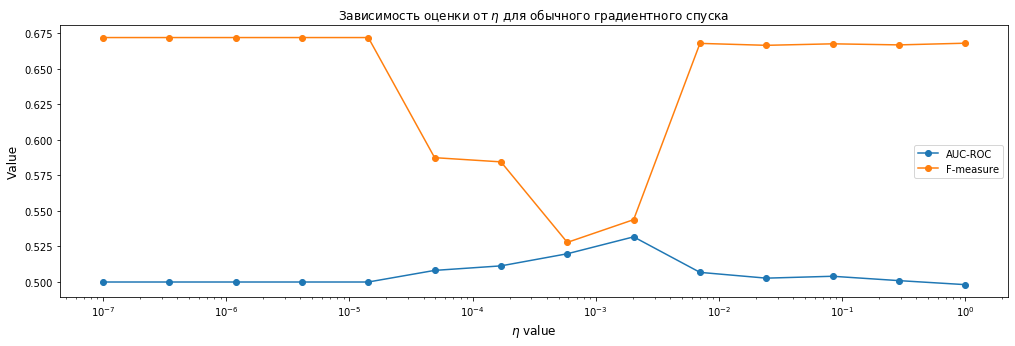

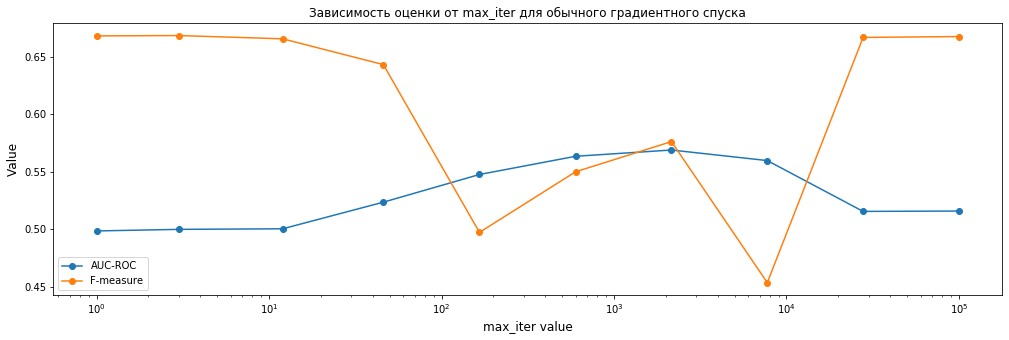

In [10]:
print('## Full gradient method ##')
# ---  alpha change --- #
pplot_log([logspace_alpha_full, logspace_alpha_full], [aucroc_f1_alpha_full.T[0], aucroc_f1_alpha_full.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от $\eta$ для обычного градиентного спуска',
          xlabel='$\eta$ value', ylabel='Value', mode='multi')

# --- max_iter change --- # 
pplot_log([logspace_max_iter_full, logspace_max_iter_full], [aucroc_f1_max_iter_full.T[0], aucroc_f1_max_iter_full.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от max_iter для обычного градиентного спуска',
          xlabel='max_iter value', ylabel='Value', mode='multi')


In [11]:
print('## Stochastic gradient method ##')
# --- calculating --- #
logspace_alpha_st = np.logspace(-8, 1, num=14, base=10)
logspace_max_iter_st = np.logspace(1, 5, num=12, base=10, dtype=int)

aucroc_f1_alpha_st = np.array(list(map(lambda x: aucroc_f1_calculate_st(x, 10000), logspace_alpha_st)))
print(aucroc_f1_alpha_st, logspace_alpha_st)

aucroc_f1_max_iter_st = np.array(list(map(lambda x: aucroc_f1_calculate_st(5*1e-3, x), logspace_max_iter_st)))
print(aucroc_f1_max_iter_st, logspace_max_iter_st)


## Stochastic gradient method ##
1e-08 10000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


4.9238826317067414e-08 10000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


2.424462017082331e-07 10000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


1.1937766417144358e-06 10000
5.878016072274912e-06 10000
2.8942661247167517e-05 10000
0.00014251026703029964 10000
0.0007017038286703822 10000
0.003455107294592218 10000
0.017012542798525893 10000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.08376776400682924 10000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.4124626382901348 10000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


2.030917620904731 10000
10.0 10000


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


[[0.5154849  0.66666667]
 [0.51462477 0.66323907]
 [0.54072853 0.65884116]
 [0.57903938 0.58053803]
 [0.58003553 0.58167331]
 [0.58347469 0.59302704]
 [0.57587493 0.58322412]
 [0.57740848 0.57761492]
 [0.54149131 0.2989899 ]
 [0.5206163  0.14369847]
 [0.50738906 0.66953178]
 [0.50992276 0.08266502]
 [0.50032938 0.00131666]
 [0.50283641 0.03207184]] [1.00000000e-08 4.92388263e-08 2.42446202e-07 1.19377664e-06
 5.87801607e-06 2.89426612e-05 1.42510267e-04 7.01703829e-04
 3.45510729e-03 1.70125428e-02 8.37677640e-02 4.12462638e-01
 2.03091762e+00 1.00000000e+01]
0.005 10
0.005 28
0.005 81
0.005 231
0.005 657
0.005

F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


 1873


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.005 5336


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.005 15199


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.005 43287


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.005 123284
0.005 351119
0.005 1000000
[[0.50414593 0.03833866]
 [0.50567282 0.0625    ]
 [0.54464376 0.37226277]
 [0.55446251 0.52534562]
 [0.56099545 0.55139551]
 [0.56890192 0.57536946]
 [0.57549887 0.59567705]
 [0.5754802  0.5730563 ]
 [0.51690643 0.66589003]
 [0.51922677 0.14836449]
 [0.51049751 0.66954939]
 [0.52926955 0.20056022]] [     10      28      81     231     657    1873    5336   15199   43287
  123284  351119 1000000]


## Stochastic gradient method ##


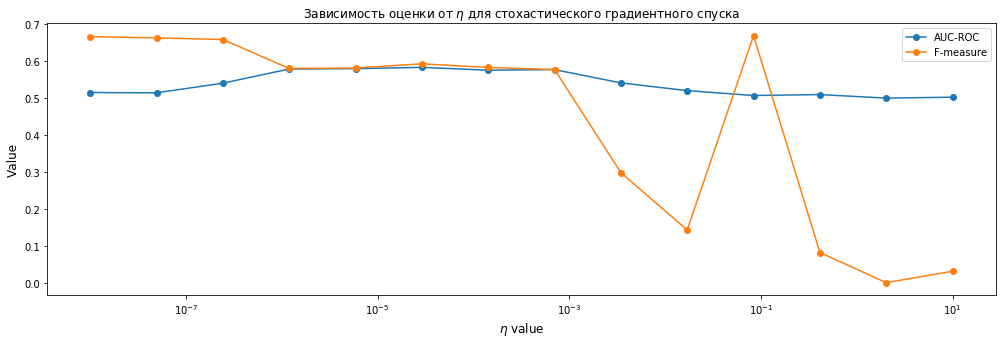

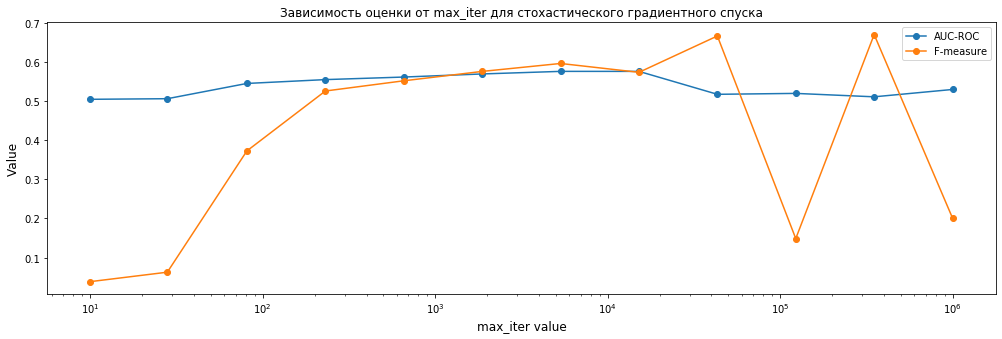

In [12]:
print('## Stochastic gradient method ##')
# ---  alpha change --- #
pplot_log([logspace_alpha_st, logspace_alpha_st], [aucroc_f1_alpha_st.T[0], aucroc_f1_alpha_st.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от $\eta$ для стохастического градиентного спуска',
          xlabel='$\eta$ value', ylabel='Value', mode='multi')

# --- max_iter change --- # 
pplot_log([logspace_max_iter_st, logspace_max_iter_st], [aucroc_f1_max_iter_st.T[0], aucroc_f1_max_iter_st.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от max_iter для стохастического градиентного спуска',
          xlabel='max_iter value', ylabel='Value', mode='multi')


In [13]:
print('## Momentum gradient method ##')
# --- calculating --- #
logspace_alpha_mm = np.logspace(-8, 1, num=14, base=10)
logspace_max_iter_mm = np.logspace(1, 5, num=12, base=10, dtype=int)
logspace_nu_mm = np.linspace(0, 1, num=25)

aucroc_f1_alpha_mm = np.array(list(map(lambda x: aucroc_f1_calculate_mm(x, 10000, 0.002), logspace_alpha_mm)))
print(aucroc_f1_alpha_mm, logspace_alpha_mm)

aucroc_f1_max_iter_mm = np.array(list(map(lambda x: aucroc_f1_calculate_mm(1e-3, x, 0.002), logspace_max_iter_mm)))
print(aucroc_f1_max_iter_mm, logspace_max_iter_mm)

aucroc_f1_nu_mm = np.array(list(map(lambda x: aucroc_f1_calculate_mm(1e-3, 10000, x), logspace_nu_mm)))
print(aucroc_f1_nu_mm, logspace_nu_mm)

## Momentum gradient method ##
1e-08 10000 0.002
4.9238826317067414e-08 10000 0.002
2.424462017082331e-07 10000 0.002
1.1937766417144358e-06 10000 0.002
5.878016072274912e-06 10000 0.002
2.8942661247167517e-05 10000 0.002
0.00014251026703029964 10000 0.002
0.0007017038286703822 10000 0.002
0.003455107294592218 10000 0.002
0.017012542798525893 10000 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.08376776400682924 10000 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.4124626382901348 10000 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


2.030917620904731 10000 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


10.0 10000 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


[[0.53252335 0.21495845]
 [0.54728281 0.29656234]
 [0.5840321  0.54723127]
 [0.58385874 0.57988564]
 [0.58153707 0.57710438]
 [0.58271858 0.5837766 ]
 [0.58076763 0.59175057]
 [0.57830194 0.59383033]
 [0.5125338  0.09541284]
 [0.54014845 0.26645603]
 [0.50665029 0.67042127]
 [0.50277907 0.67171492]
 [0.50374454 0.04804046]
 [0.5        0.67197875]] [1.00000000e-08 4.92388263e-08 2.42446202e-07 1.19377664e-06
 5.87801607e-06 2.89426612e-05 1.42510267e-04 7.01703829e-04
 3.45510729e-03 1.70125428e-02 8.37677640e-02 4.12462638e-01
 2.03091762e+00 1.00000000e+01]
0.001 10 0.002
0.001 23 0.002
0.001 53 0.002
0.001 123 0.002
0.001 284 0.002
0.001 657 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.001 1519 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.001 3511 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


0.001 8111 0.002
0.001 18738 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.001 43287 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.001 100000 0.002


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


[[0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.49809573 0.66889186]
 [0.53030436 0.47530635]
 [0.55341169 0.54028111]
 [0.56980205 0.57980456]
 [0.56187024 0.54400554]] [    10     23     53    123    284    657   1519   3511   8111  18738
  43287 100000]
0.001 10000 0.0
0.001 10000 0.041666666666666664
0.001 10000 0.08333333333333333
0.001 10000 0.125
0.001 10000 0.16666666666666666
0.001 10000 0.20833333333333331
0.001 10000 0.25
0.001 10000 0.29166666666666663
0.001 10000 0.3333333333333333
0.001 10000 0.375
0.001 10000 0.41666666666666663
0.001 10000 0.4583333333333333
0.001 10000 0.5
0.001 10000 0.5416666666666666
0.001 10000 0.5833333333333333
0.001 10000 0.625
0.001 10000 0.6666666666666666
0.001 10000 0.7083333333333333
0.001 10000 0.75
0.001 10000 0.7916666666666666
0.001 10000 0.8333333333333333
0.001 10000 0.875
0.001 10000 0.9166666666666666
0.

F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


[[0.56574413 0.5658114 ]
 [0.57009009 0.56971314]
 [0.56546143 0.55077453]
 [0.56925531 0.575     ]
 [0.57303985 0.58629606]
 [0.56398255 0.44189992]
 [0.56921797 0.5988806 ]
 [0.58917151 0.53232514]
 [0.57950612 0.58804312]
 [0.54590128 0.65892451]
 [0.52439151 0.66123232]
 [0.58557899 0.50884782]
 [0.55023123 0.3058104 ]
 [0.5689606  0.40691853]
 [0.54116193 0.65694898]
 [0.56284772 0.40629213]
 [0.54810559 0.36759259]
 [0.57206371 0.44739093]
 [0.54991785 0.3035258 ]
 [0.54570792 0.28556594]
 [0.55337702 0.64591647]
 [0.56737504 0.63190883]
 [0.51615166 0.66713027]
 [0.53760141 0.41114394]
 [0.51840398 0.64183954]] [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]


## Momentum gradient method ##


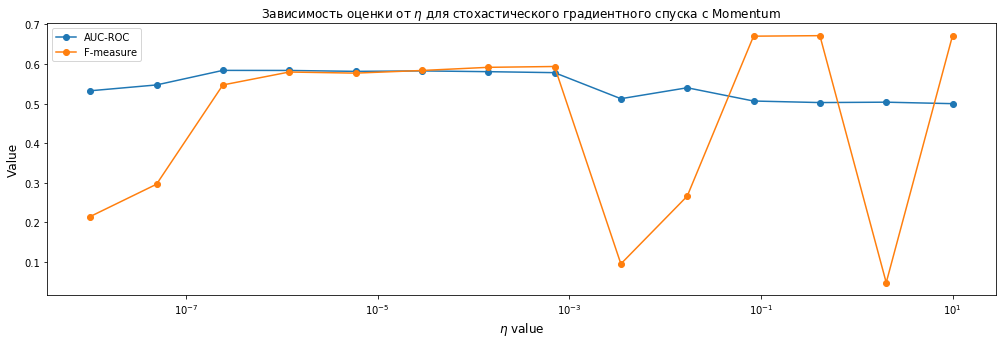

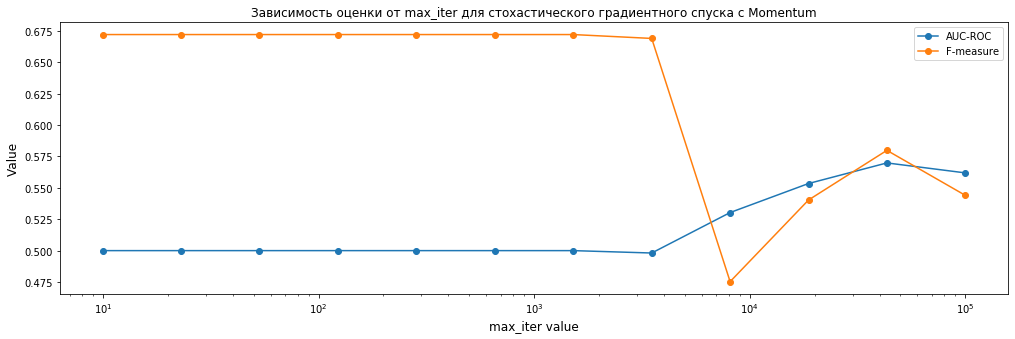

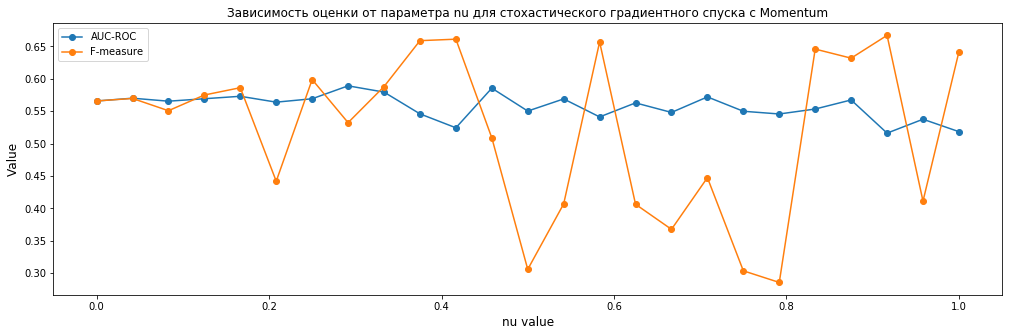

In [14]:
print('## Momentum gradient method ##')
# ---  alpha change --- #
pplot_log([logspace_alpha_mm, logspace_alpha_mm], [aucroc_f1_alpha_mm.T[0], aucroc_f1_alpha_mm.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от $\eta$ для стохастического градиентного спуска c Momentum',
          xlabel='$\eta$ value', ylabel='Value', mode='multi')

# # --- max_iter change --- # 
pplot_log([logspace_max_iter_mm, logspace_max_iter_mm], [aucroc_f1_max_iter_mm.T[0], aucroc_f1_max_iter_mm.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от max_iter для стохастического градиентного спуска c Momentum',
          xlabel='max_iter value', ylabel='Value', mode='multi')

# # --- nu change --- # 
pplot_log([logspace_nu_mm, logspace_nu_mm], [aucroc_f1_nu_mm.T[0], aucroc_f1_nu_mm.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от параметра nu для стохастического градиентного спуска c Momentum',
          xlabel='nu value', ylabel='Value', mode='multi', scale='linear')

In [15]:
print('## Adam gradient method ##')
# --- calculating --- #
logspace_alpha_adam = np.logspace(-8, 1, num=14, base=10)
logspace_max_iter_adam = np.logspace(1, 5, num=12, base=10, dtype=int)
logspace_beta_1_adam = np.linspace(0, 1, num=25)
logspace_beta_2_adam = np.linspace(0, 1, num=25)

aucroc_f1_alpha_adam = np.array(list(map(lambda x: aucroc_f1_calculate_adam(x, 10000, 0.9, 0.99), logspace_alpha_adam)))
print(aucroc_f1_alpha_adam, logspace_alpha_adam)

aucroc_f1_max_iter_adam = np.array(list(map(lambda x: aucroc_f1_calculate_adam(1e-3, x, 0.9, 0.99), logspace_max_iter_adam)))
print(aucroc_f1_max_iter_adam, logspace_max_iter_adam)

aucroc_f1_beta_1_adam = np.array(list(map(lambda x: aucroc_f1_calculate_adam(1e-3, 10000, x, 0.99), logspace_beta_1_adam)))
print(aucroc_f1_beta_1_adam, logspace_beta_1_adam)

aucroc_f1_beta_2_adam = np.array(list(map(lambda x: aucroc_f1_calculate_adam(1e-3, 10000, 0.9, x), logspace_beta_2_adam)))
print(aucroc_f1_beta_2_adam, logspace_beta_2_adam)

## Adam gradient method ##
1e-08 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


4.9238826317067414e-08 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


2.424462017082331e-07 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


1.1937766417144358e-06 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


5.878016072274912e-06 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


2.8942661247167517e-05 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.00014251026703029964 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.0007017038286703822 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.003455107294592218 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.017012542798525893 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.08376776400682924 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.4124626382901348 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


2.030917620904731 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


10.0 10000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


[[0.51840398 0.64183954]
 [0.51840398 0.64183954]
 [0.52009089 0.64264264]
 [0.52256458 0.64125221]
 [0.525485   0.62074511]
 [0.55136073 0.51176258]
 [0.56381319 0.53461129]
 [0.56898993 0.57227919]
 [0.56559211 0.57124054]
 [0.51889739 0.66065068]
 [0.53795613 0.28145865]
 [0.5076371  0.66483138]
 [0.50050541 0.66905028]
 [0.5        0.67197875]] [1.00000000e-08 4.92388263e-08 2.42446202e-07 1.19377664e-06
 5.87801607e-06 2.89426612e-05 1.42510267e-04 7.01703829e-04
 3.45510729e-03 1.70125428e-02 8.37677640e-02 4.12462638e-01
 2.03091762e+00 1.00000000e+01]
0.001 10 0.9 0.99
0.001 23 0.9 0.99
0.001 53 0.9 0.99
0.001 123 0.9 0.99
0.001 284 0.9 0.99
0.001 657 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.001 1519 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.001 3511 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: overflow encountered in exp


0.001 8111 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.001 18738 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.001 43287 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


0.001 100000 0.9 0.99


F:\anaconda3\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log


[[0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.5        0.67197875]
 [0.52436884 0.62287234]
 [0.52779334 0.58519389]
 [0.55850042 0.57933227]
 [0.56740704 0.56762159]
 [0.55791234 0.56410256]
 [0.57518416 0.58338784]] [    10     23     53    123    284    657   1519   3511   8111  18738
  43287 100000]
0.001 10000 0.0 0.99
0.001 10000 0.041666666666666664 0.99
0.001 10000 0.08333333333333333 0.99
0.001 10000 0.125 0.99
0.001 10000 0.16666666666666666 0.99
0.001 10000 0.20833333333333331 0.99
0.001 10000 0.25 0.99
0.001 10000 0.29166666666666663 0.99
0.001 10000 0.3333333333333333 0.99
0.001 10000 0.375 0.99
0.001 10000 0.41666666666666663 0.99
0.001 10000 0.4583333333333333 0.99
0.001 10000 0.5 0.99
0.001 10000 0.5416666666666666 0.99
0.001 10000 0.5833333333333333 0.99
0.001 10000 0.625 0.99
0.001 10000 0.6666666666666666 0.99
0.001 10000 0.7083333333333333 0.99
0.001 10000 0.75 0.99
0.001 10000 0.7916

## Adam gradient method ##


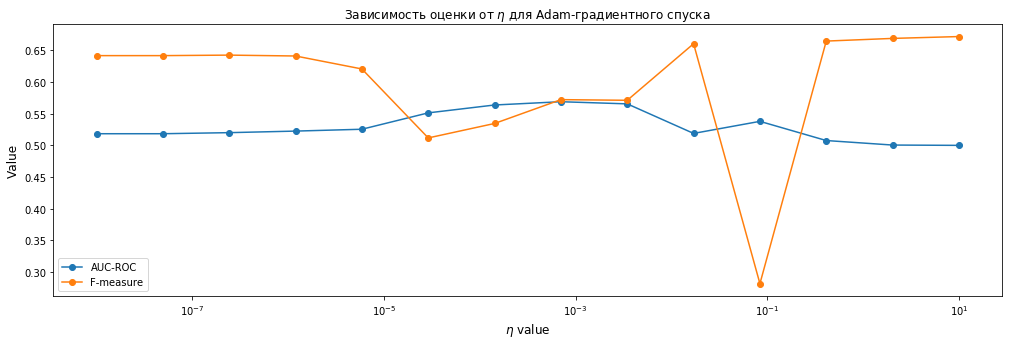

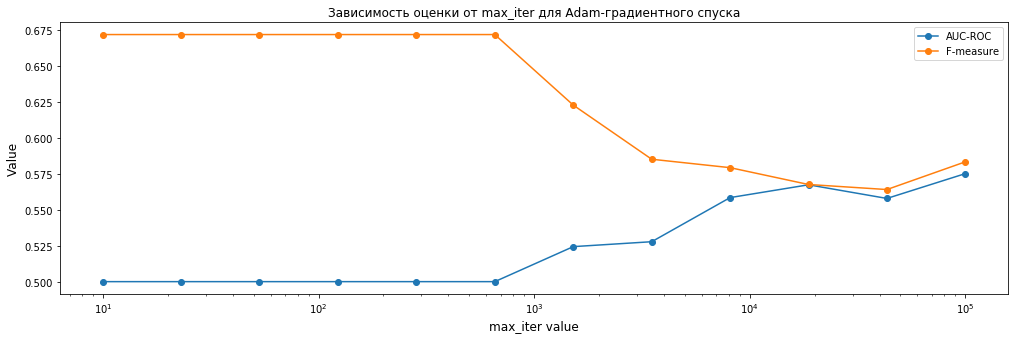

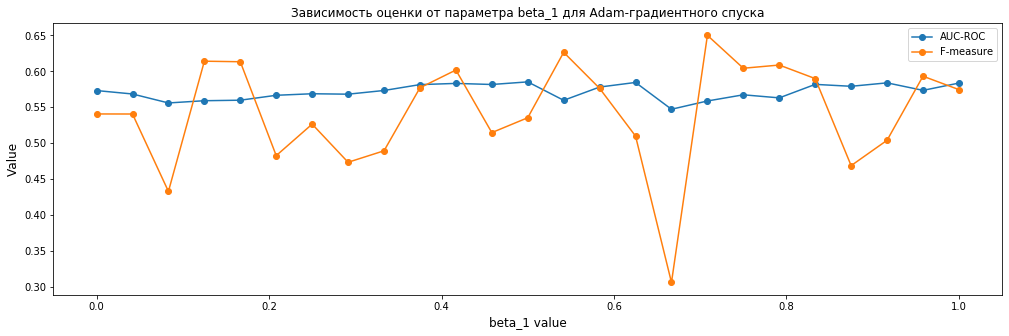

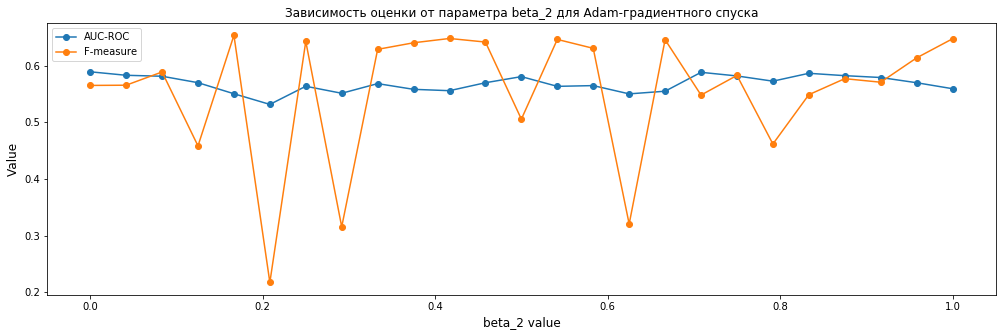

In [16]:
print('## Adam gradient method ##')
# ---  alpha change --- #
pplot_log([logspace_alpha_adam, logspace_alpha_adam], [aucroc_f1_alpha_adam.T[0], aucroc_f1_alpha_adam.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от $\eta$ для Adam-градиентного спуска',
          xlabel='$\eta$ value', ylabel='Value', mode='multi')

# # --- max_iter change --- # 
pplot_log([logspace_max_iter_adam, logspace_max_iter_adam], [aucroc_f1_max_iter_adam.T[0], aucroc_f1_max_iter_adam.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от max_iter для Adam-градиентного спуска',
          xlabel='max_iter value', ylabel='Value', mode='multi')

# # --- beta_1 change --- # 
pplot_log([logspace_beta_1_adam, logspace_beta_1_adam], [aucroc_f1_beta_1_adam.T[0], aucroc_f1_beta_1_adam.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от параметра beta_1 для Adam-градиентного спуска',
          xlabel='beta_1 value', ylabel='Value', mode='multi', scale='linear')

# # --- beta_2 change --- # 
pplot_log([logspace_beta_2_adam, logspace_beta_2_adam], [aucroc_f1_beta_2_adam.T[0], aucroc_f1_beta_2_adam.T[1]], 
          label_plot=['AUC-ROC', 'F-measure'],
          title='Зависимость оценки от параметра beta_2 для Adam-градиентного спуска',
          xlabel='beta_2 value', ylabel='Value', mode='multi', scale='linear')


Зависимость оценки AUC-ROC от learing rate для каждого из методов


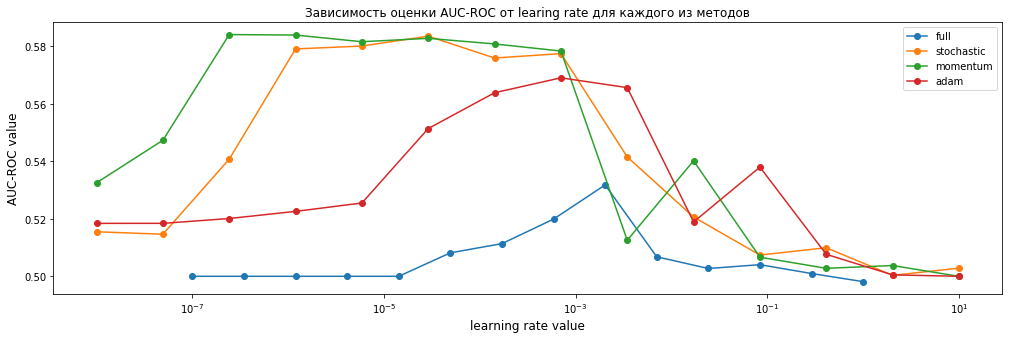

Зависимость оценки F-меры от learing rate для каждого из методов


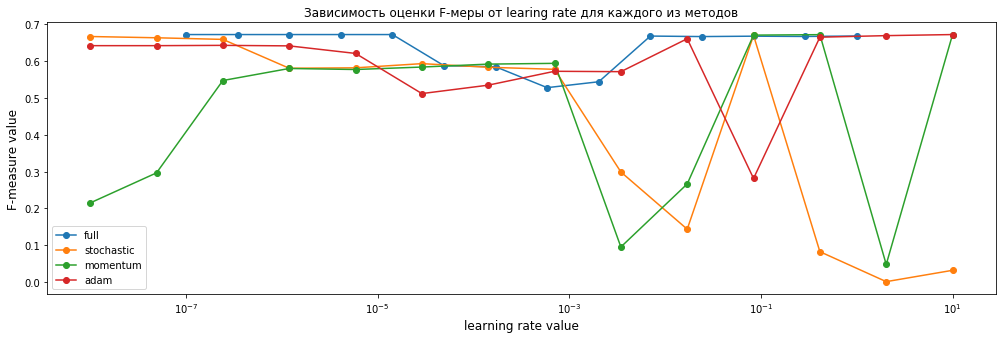

In [17]:
print('Зависимость оценки AUC-ROC от learing rate для каждого из методов')
pplot_log([logspace_alpha_full, logspace_alpha_st, logspace_alpha_mm, logspace_alpha_adam], 
          [aucroc_f1_alpha_full.T[0], aucroc_f1_alpha_st.T[0], aucroc_f1_alpha_mm.T[0], aucroc_f1_alpha_adam.T[0]], 
          label_plot=['full', 'stochastic', 'momentum', 'adam'],
          title='Зависимость оценки AUC-ROC от learing rate для каждого из методов',
          xlabel='learning rate value', ylabel='AUC-ROC value', mode='multi')

print('Зависимость оценки F-меры от learing rate для каждого из методов')
pplot_log([logspace_alpha_full, logspace_alpha_st, logspace_alpha_mm, logspace_alpha_adam], 
          [aucroc_f1_alpha_full.T[1], aucroc_f1_alpha_st.T[1], aucroc_f1_alpha_mm.T[1], aucroc_f1_alpha_adam.T[1]], 
          label_plot=['full', 'stochastic', 'momentum', 'adam'],
          title='Зависимость оценки F-меры от learing rate для каждого из методов',
          xlabel='learning rate value', ylabel='F-measure value', mode='multi')

Зависимость оценки AUC-ROC от max_iter для каждого из методов


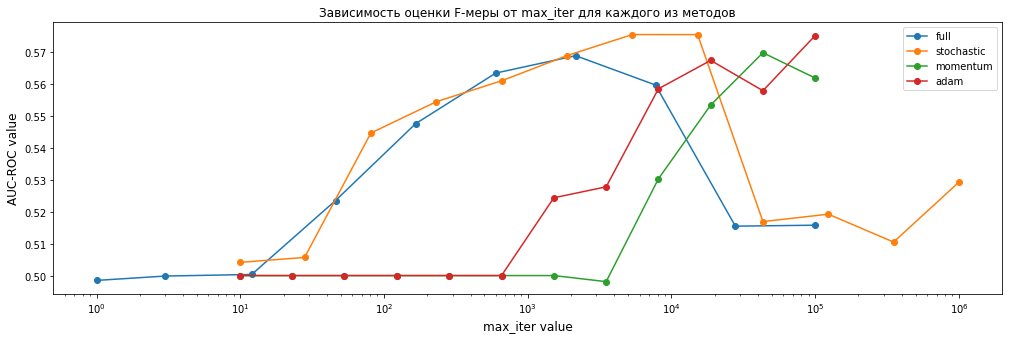

Зависимость оценки F-меры от max_iter для каждого из методов


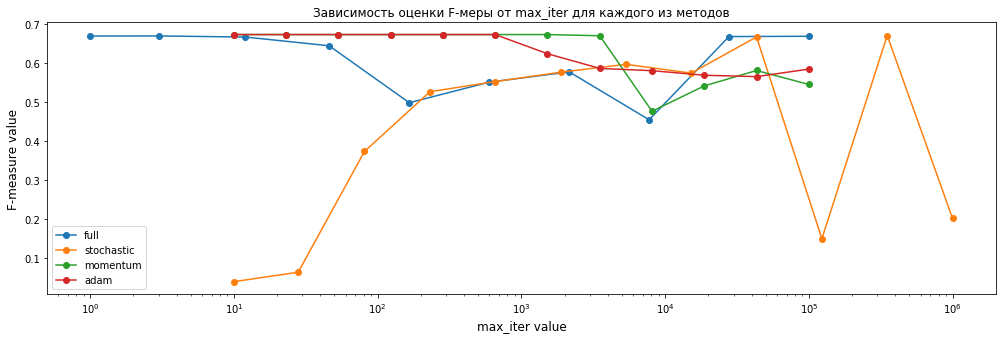

In [18]:
print('Зависимость оценки AUC-ROC от max_iter для каждого из методов')
pplot_log([logspace_max_iter_full, logspace_max_iter_st, logspace_max_iter_mm, logspace_max_iter_adam], 
          [aucroc_f1_max_iter_full.T[0], aucroc_f1_max_iter_st.T[0], aucroc_f1_max_iter_mm.T[0], aucroc_f1_max_iter_adam.T[0]], 
          label_plot=['full', 'stochastic', 'momentum', 'adam'],
          title='Зависимость оценки F-меры от max_iter для каждого из методов',
          xlabel='max_iter value', ylabel='AUC-ROC value', mode='multi')

print('Зависимость оценки F-меры от max_iter для каждого из методов')
pplot_log([logspace_max_iter_full, logspace_max_iter_st, logspace_max_iter_mm, logspace_max_iter_adam], 
          [aucroc_f1_max_iter_full.T[1], aucroc_f1_max_iter_st.T[1], aucroc_f1_max_iter_mm.T[1], aucroc_f1_max_iter_adam.T[1]], 
          label_plot=['full', 'stochastic', 'momentum', 'adam'],
          title='Зависимость оценки F-меры от max_iter для каждого из методов',
          xlabel='max_iter value', ylabel='F-measure value', mode='multi')


**Выводы:** 

1. Метод `'full'` дает более "гладкое" распределение. Это объясняется тем, что в нем не используются случайные величины.
2. Как и ожидалось, оценка становится лучше с увеличением параметра `max_iter`, но при этом, на достаточно большом количестве итераций, оценка уменьшается (на всех кроме `'momentum'`). 
3. Как и предполагалось, для очень маленьких `alpha` (выше оно названо `eta` по аналогии с условием, но везде до этого learning rate обозначался за `alpha`) оценка хуже. Это можно объяснить тем, что градиент просто не успевает добраться. Для очень больших `alpha` оценка тоже уменьшается, это уже связано с тем, что мы просто "перескакиваем" верный градиент.

**Задание 6 (1.5 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом Momentum. Постройте аналогичные графики для зависимости от времени работы в секундах. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Назовём график *красивым*, если он соответствует требованиям, предъявленным к графикам в первом дз. В этом задании от вас требуются красивые графики.

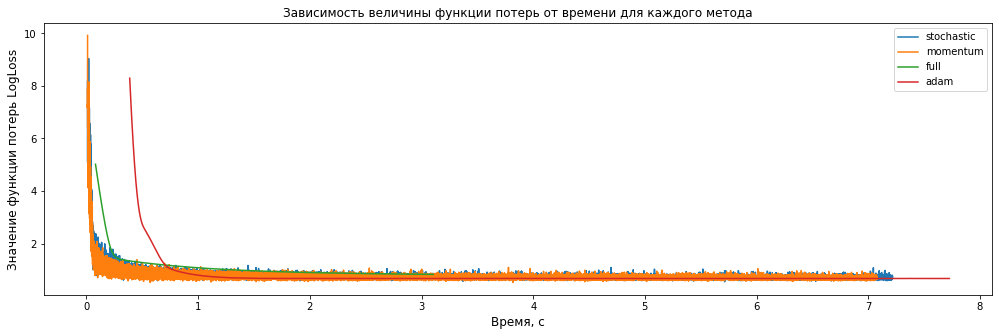

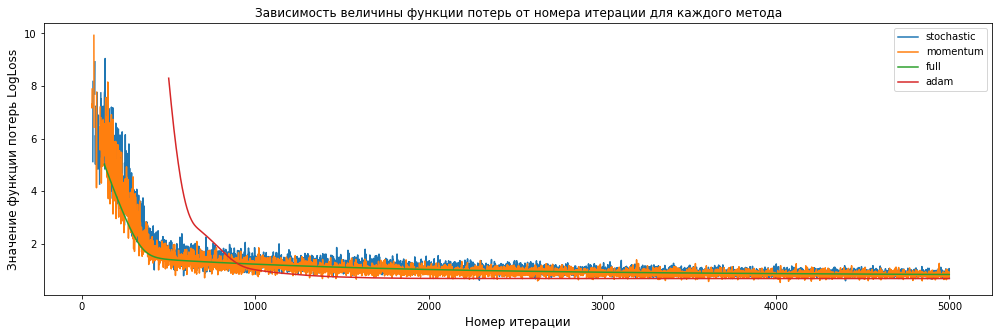

In [19]:
r = min(lr_full.max_iter, lr_st.max_iter, lr_mm.max_iter, lr_adam.max_iter)

pplot_log([np.linspace(0, time_st, len(lr_st.loss_history)), 
           np.linspace(0, time_mm, len(lr_mm.loss_history)),
           np.linspace(0, time_full, len(lr_full.loss_history)),
           np.linspace(0, time_adam, len(lr_adam.loss_history))
          ], 
          [lr_st.loss_history, 
           lr_mm.loss_history,
           lr_full.loss_history,
           lr_adam.loss_history
          ], 
          label_plot=['stochastic', 'momentum', 'full', 'adam'],
          title='Зависимость величины функции потерь от времени для каждого метода',
          xlabel='Время, с', ylabel='Значение функции потерь LogLoss', mode='multi', marker=['', '', '', ''], scale='linear')


pplot_log([range(r), 
           range(r), 
           range(r), 
           range(r)
          ], 
          [lr_st.loss_history[:r], 
           lr_mm.loss_history[:r],
           lr_full.loss_history[:r],
           lr_adam.loss_history[:r]
          ],
          label_plot=['stochastic', 'momentum', 'full', 'adam'],
          title='Зависимость величины функции потерь от номера итерации для каждого метода',
          xlabel='Номер итерации', ylabel='Значение функции потерь LogLoss', mode='multi', marker=['', '', '', ''], scale='linear')

**Выводы:** 
Как мы видим, ошибка уменьшается со временем и с кол-ом итераций (как и ожидалось). Стоит заметить, что ошибка метода `full` уменьшается "быстрее" всего. А у стохастики и моментума есть характерные "биения", это, очевидно, связано с тем, что мы берем случайное каждый раз.

### Бонус

Бонусные задачи оцениваются особенно строго. Оценка может быть снижена за плохой код и даже за некрасивые названия переменных. Подсказок не даём.

**Задание 7 (0.5 баллов)**. Правда ли, что лог-лосс является выпуклой функцией относительно $w$? Правда ли, что она является Липшицевой относительно $w$? Почему?

**Задание 8 (3 балла)**. В этом задании на 2 балла засчитывается один из двух пунктов:
 * Реализуйте логистическую регрессию с лог-лоссом, обучаемую с помощью метода [Adam](https://arxiv.org/pdf/1412.6980.pdf)
 * Реализуйте логистическую регрессию с лог-лоссом, обучаемую с помощью [метода Ньютона](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization)

добавьте при необходимости параметры в класс модели, повторите пункты 5 и 6 и сравните результаты.

На 3 балла засчитываются оба пункта со сравнением методов и выводами.

##### Метод Адам

* метод Adam добавлен в первоначальный класс, использовать его можно при `gd_type='adam'`, также имеются два параметра `beta_1`, `beta_2` (ровно как взяты из статьи). Доступ к аналогичным предыдущим результатам можно получить поменяв `_full`, `_st`, `_mm` на `_adam`. Результаты, графики и прочее расчитаны в самих заданиях 5 и 6.

* Вывод: методу адам нужно вначале какое-то время\кол-во итераций, после которого метод начнет учиться быстрее остальных. Также стоит заметить, что для больших learning rate он показывает себя плохо (ровно как и остальные методы, так что это вполне ожидаемо)

**Задание 9 (0.00 баллов)**.  Вставьте ниже самый смешной или самый грустный график, который получился у вас в этом дз.

Смешных или грустных графиков не было замечено, но зато посмотрите какой мем я в процессе делания дз нашел:

![The Meme](https://sun9-55.userapi.com/c856124/v856124752/21261b/apZCLon6qHE.jpg "Meme")

## Часть 2: линейная регрессия и feature importance

В этой части мы проанализируем то, как работает линейная регрессия и регуляризация. Тут уже можно пользоваться sklearn'ом.

__Задание 9__ (0 баллов). Загрузите обучающие данные из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/data). Разделите выборку в отношении 7:3. Преобразуйте целевую переменную (trip_duration) как $\widetilde{y} = \log(1 + y)$. Удалите столбец id, а также столбцы, содержащие дату и время. Отнормируйте признаки при помощи MinMaxScaler'a. Как вы думаете, почему такое преобразование имеет смысл?

In [20]:
df = pd.read_csv('data/newyork_taxi.csv',  index_col='id')
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


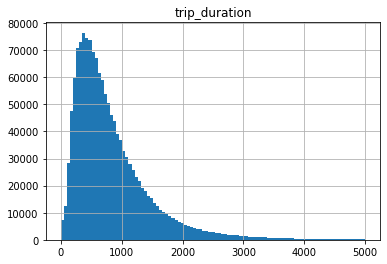

In [21]:
from sklearn.preprocessing import MinMaxScaler as scaler
from sklearn.model_selection import train_test_split

X = np.array(df.loc[:, ~df.columns.isin(['pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag', 'trip_duration'])])
y = np.log(1 + np.array(df['trip_duration']))

X = scaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

df.hist(column = 'trip_duration', bins = np.linspace(0, 5000, 100))
plt.show()

Приминение преобразования $log(1+y)$ "логарифмизирует" функцию, но при этом сохраняет нуль на месте.
Это всё позволяет "сильнее" видеть разницу между короткими поездками и совсем мало различать длинные. Почему это нужно?

Давайте рассмотрим как распределена целевая переменная. 
Построив гистограмму видим, что основная часть сконцентрирована на "коротких" поездках.

__Задание 10__ (1 балл). Обучите три вида линейной регрессии на получившихся данных: обычную, Ridge и Lasso. Оцените качество при помощи MSE и $R^2$. 


- Обычная -- без регуляризации $\lambda_1$ и $\lambda_2$ равны нулю;
- Ridge -- L2 регуляризация, то есть только $\lambda_1$ равна нулю;
- Lasso -- L1 регуляризация, то есть только $\lambda_2$ равна нулю;

In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

lr_common = LinearRegression()
lr_common.fit(X_train, y_train)

lr_ridge = Ridge()
lr_ridge.fit(X_train, y_train)

lr_lasso = Lasso()
lr_lasso.fit(X_train, y_train)

print('\n!!!Done fitting!!!')


!!!Done fitting!!!


In [23]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_common = lr_common.predict(X_test)
y_pred_ridge = lr_ridge.predict(X_test)
y_pred_lasso = lr_lasso.predict(X_test)

print('MSE value for common lin-reg= \t{}'.format(mean_squared_error(y_test, y_pred_common)))
print('MSE value for Ridge lin-reg= \t{}'.format(mean_squared_error(y_test, y_pred_ridge)))
print('MSE value for Lasso lin-reg= \t{}'.format(mean_squared_error(y_test, y_pred_lasso)))

print('\n')

print('R^2 value for common lin-reg= \t{}'.format(r2_score(y_test, y_pred_common)))
print('R^2 value for Ridge lin-reg= \t{}'.format(r2_score(y_test, y_pred_ridge)))
print('R^2 value for Lasso lin-reg= \t{}'.format(r2_score(y_test, y_pred_lasso)))

MSE value for common lin-reg= 	0.6064584443601355
MSE value for Ridge lin-reg= 	0.6091347049288874
MSE value for Lasso lin-reg= 	0.6330082354995006


R^2 value for common lin-reg= 	0.04193819641484042
R^2 value for Ridge lin-reg= 	0.037710333729100265
R^2 value for Lasso lin-reg= 	-4.23347518574424e-06


__Задание 11__ (1 балл). Постройте графики зависимости значения метрик из предыдущего задания от значения коэффициента регуляризации для методов Lasso и Ridge. Какие выводы можно сделать?

In [24]:
def mse_r2_calculate_lasso(alpha):
    print(alpha)
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    return mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

def mse_r2_calculate_ridge(alpha):
    print(alpha)
    lr = Ridge(alpha=alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    return mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

In [25]:
# --- calculating ---  #
logspace = np.logspace(-6, 3, num=25, base=10)
print('## Lasso reg ##')
mse_r2_lasso = np.array(list(map(lambda x: mse_r2_calculate_lasso(x), logspace)))

print('## Ridge reg ##')
mse_r2_ridge = np.array(list(map(lambda x: mse_r2_calculate_ridge(x), logspace)))

## Lasso reg ##
1e-06
2.3713737056616552e-06
5.623413251903491e-06
1.333521432163324e-05
3.1622776601683795e-05
7.498942093324559e-05
0.00017782794100389227
0.00042169650342858224
0.001
0.0023713737056616554
0.005623413251903491
0.01333521432163324
0.03162277660168379
0.07498942093324558
0.1778279410038923
0.4216965034285822
1.0
2.371373705661655
5.623413251903491
13.33521432163324
31.622776601683793
74.98942093324558
177.82794100389228
421.6965034285823
1000.0
## Ridge reg ##
1e-06
2.3713737056616552e-06
5.623413251903491e-06
1.333521432163324e-05
3.1622776601683795e-05
7.498942093324559e-05
0.00017782794100389227
0.00042169650342858224
0.001
0.0023713737056616554
0.005623413251903491
0.01333521432163324
0.03162277660168379
0.07498942093324558
0.1778279410038923
0.4216965034285822
1.0
2.371373705661655
5.623413251903491
13.33521432163324
31.622776601683793
74.98942093324558
177.82794100389228
421.6965034285823
1000.0


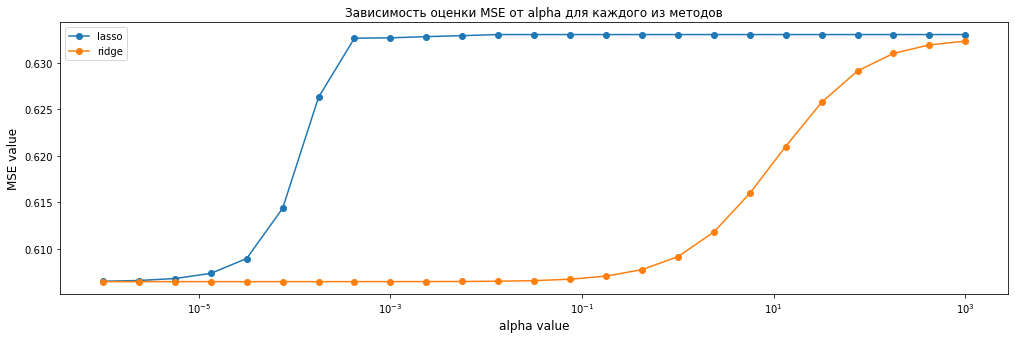

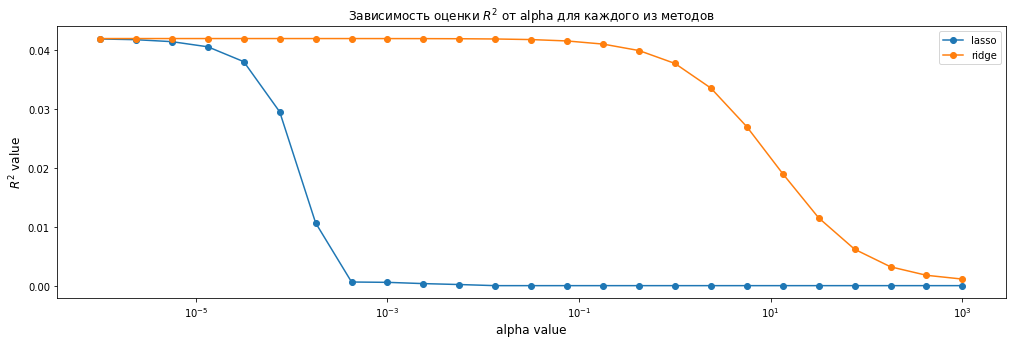

In [26]:
pplot_log([logspace, logspace], 
          [mse_r2_lasso.T[0], mse_r2_ridge.T[0]], 
          label_plot=['lasso', 'ridge'],
          title='Зависимость оценки MSE от alpha для каждого из методов',
          xlabel='alpha value', ylabel='MSE value', mode='multi')

pplot_log([logspace, logspace], 
          [mse_r2_lasso.T[1], mse_r2_ridge.T[1]], 
          label_plot=['lasso', 'ridge'],
          title='Зависимость оценки $R^2$ от alpha для каждого из методов',
          xlabel='alpha value', ylabel='$R^2$ value', mode='multi')

Хорошие ли получились результаты?

__Задание 12__ (0.5 баллов). При помощи кросс-валидации найдите оптимальные значения коэффициента регуляризации для методов Ridge и Lasso.

__Задание 13__ (0.5 баллов). Постройте bar plot весов признаков для каждой из трёх моделей (на одном рисунке). Какие выводы можно сделать?

Какие фичи оказались наиболее важными? Согласуется ли это с вашими ожиданиями?

__Задание 14__ (2 балла). Добавьте в датасет дополнительные признаки, основываясь на существующих, чтобы получить значение метрики MSE не более 0.4. Что вы для этого сделали?

Введём два новых признака:

1. Пройденное расстояние `length`. Вычислить его точно довольно сложно, но мы будем считать кратчайшее расстояние между точкой начала поездки $(\text{longitude}_{\text{pickup}},	\text{latitude}_{\text{pickup}})$ и конца поездки $(\text{longitude}_{\text{dropoff}},	\text{latitude}_{\text{dropoff}})$.

In [27]:
# def distance(origin, destination):
#     lon1, lat1 = origin
#     lon2, lat2 = destination
#     radius = 6371 # km

#     dlat = np.radians(lat2-lat1)
#     dlon = np.radians(lon2-lon1)
#     a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) \
#         * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
#     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
#     d = radius * c

#     return d

# df['length'] = distance((df['pickup_longitude'], df['pickup_latitude']), (df['dropoff_longitude'], df['dropoff_latitude']))

# df.head()
